In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import BlackScholes as bs
import time
import variance_curve as vc
import ImpliedDrift as iD

from scipy.optimize import least_squares as ls
from rbergomi import rBergomi

In [2]:
def price_call(S, K, N, r, q, T):
    N = len(K)
    p = np.zeros(N)
    for i in range(N):
        p[i] = np.mean(np.maximum(S[:,-1]-K[i],0)*np.exp(-(r-q)*T))
    return p

In [3]:
S0 = 4017.8
t0 = "23 Jan 2023"

IV_df = pd.read_csv("hist_spx.csv")
moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])
maturities = np.array(IV_df['Exp Date']).flatten()
IV = np.array(IV_df.drop(columns = 'Exp Date'))/100.

K = moneyness*S0/100

In [4]:
np.random.seed(0)

N = 1000; n = 1000; T = 0.5;

H = 0.1
eta = 1
rho = -0.9
alpha = H - 0.5
r = 0.03; q = 0;

rB = rBergomi(n, N, T, alpha)

xi = vc.variance_curve(rB.t[0])

dW1 = rB.dW1(); dW2 = rB.dW2();
Ya = rB.Y(dW1)
dZ = rB.dZ(dW1, dW2, rho)
        
V = rB.V(Ya, xi, eta)
        
S = rB.S(V, dZ, r, q, S0)

<IPython.core.display.Javascript object>


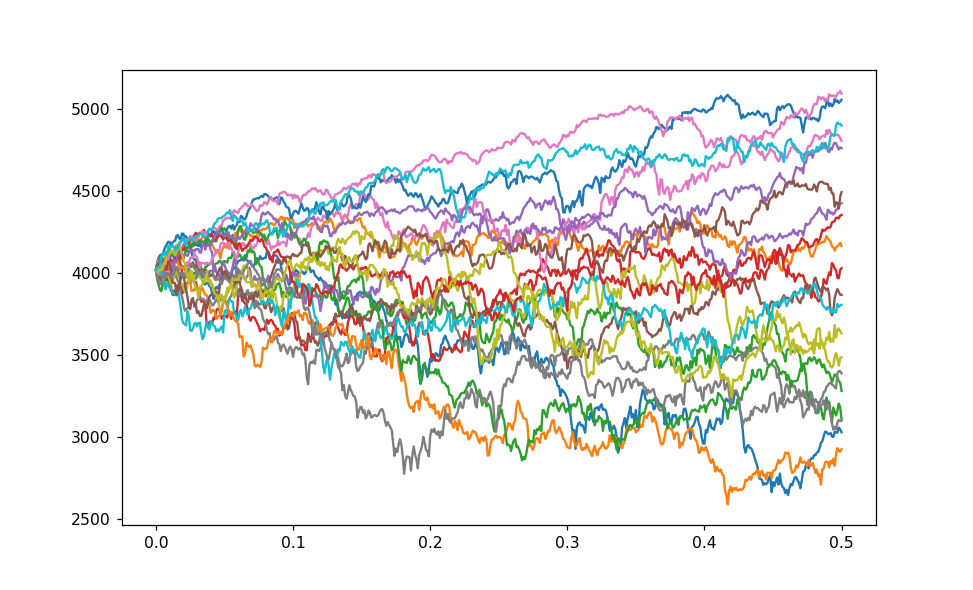

In [5]:
%matplotlib notebook

for i in range(20):
    plt.plot(rB.t[0], S[i,:])

In [6]:
nr = len(maturities); nc = len(K);
P_iv = np.zeros([nr,nc])
for i in range(nr):
    P_iv[i,:] = bs.BSCall(S0, K, maturities[i], r, q, IV[i,:])

In [8]:
start_time_all = time.time()
nr = len(maturities); nc = len(K);
rB_vol = np.zeros([nr,nc]); rB_param = np.zeros([nr,3])
inp = np.array([0.1, 1.9, -0.9]) # Parameter array [H,eta,rho]
bnds = ([.0001, 1, -0.999],[.2, 7, -.8])
N = 25000; n = 1500;
t = np.zeros(nr)

for i in range(nr):
    
    start_time = time.time()
    
    vol = IV[i]; T = maturities[i];
    
    if T > 0.5:
        N = 20000; n = 1000;
    if T > 1:
        N = 20000; n = 300;
    if T > 3:
        N = 15000; n = 100;
    
    r = iD.implied_drift(T); q = 0;
    
    if i == 0:
        q = 0.5
    
    def h(x):
    
        np.random.seed(0)

        H, eta, rho = x
        alpha = H - 0.5

        rB = rBergomi(n, N, T, alpha)
        
        xi = vc.variance_curve(rB.t[0])
        
        dW1 = rB.dW1(); dW2 = rB.dW2();
        Ya = rB.Y(dW1)
        dZ = rB.dZ(dW1, dW2, rho)
        V = rB.V(Ya, xi, eta)
        S = rB.S(V, dZ, r, q, S0)

        P = price_call(S, K, N, r, q, T)
        rB_v = bs.BSImpliedVol(S0, K, T, r, q, P, Option_type = 1, toll = 1e-5)

        return rB_v

    def f(x):
        return h(x) - vol

    result = ls(f, inp, bounds = bnds, max_nfev = 10, ftol = 1e-10, gtol = 1e-10, xtol = 1e-10)
    rB_param[i,:] = result.x
    
    t[i] = time.time() - start_time

    print(f'Iteration: {i}\t Elapsed time: {t[i]: .0f} s')
    
    rB_vol[i,:] = h(result.x)

total_time = (time.time() - start_time_all)/60

print(f'Total execution time: {total_time: .0f} minutes')

Iteration: 0	 Elapsed time:  19 s
Iteration: 1	 Elapsed time:  36 s
Iteration: 2	 Elapsed time:  67 s
Iteration: 3	 Elapsed time:  90 s
Iteration: 4	 Elapsed time:  111 s
Iteration: 5	 Elapsed time:  121 s
Iteration: 6	 Elapsed time:  128 s
Iteration: 7	 Elapsed time:  105 s
Iteration: 8	 Elapsed time:  154 s
Iteration: 9	 Elapsed time:  221 s
Iteration: 10	 Elapsed time:  134 s
Iteration: 11	 Elapsed time:  76 s
Iteration: 12	 Elapsed time:  88 s
Iteration: 13	 Elapsed time:  126 s
Iteration: 14	 Elapsed time:  139 s
Iteration: 15	 Elapsed time:  184 s
Iteration: 16	 Elapsed time:  240 s
Iteration: 17	 Elapsed time:  164 s
Iteration: 18	 Elapsed time:  201 s
Iteration: 19	 Elapsed time:  92 s
Iteration: 20	 Elapsed time:  78 s
Iteration: 21	 Elapsed time:  46 s
Iteration: 22	 Elapsed time:  126 s
Iteration: 23	 Elapsed time:  234 s
Iteration: 24	 Elapsed time:  49 s
Iteration: 25	 Elapsed time:  71 s
Iteration: 26	 Elapsed time:  87 s
Iteration: 27	 Elapsed time:  88 s
Iteration: 28	 

<IPython.core.display.Javascript object>


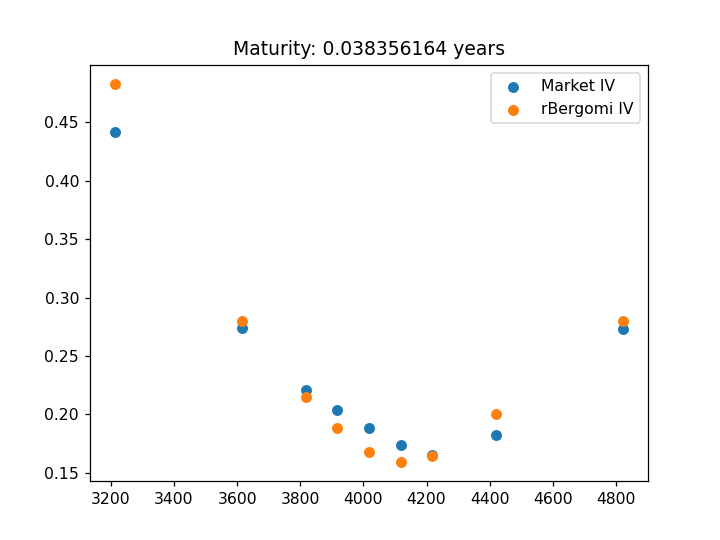

<IPython.core.display.Javascript object>


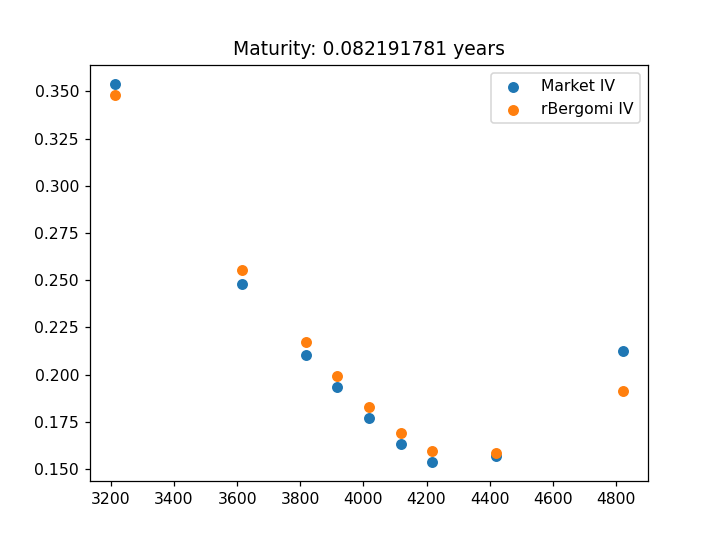

<IPython.core.display.Javascript object>


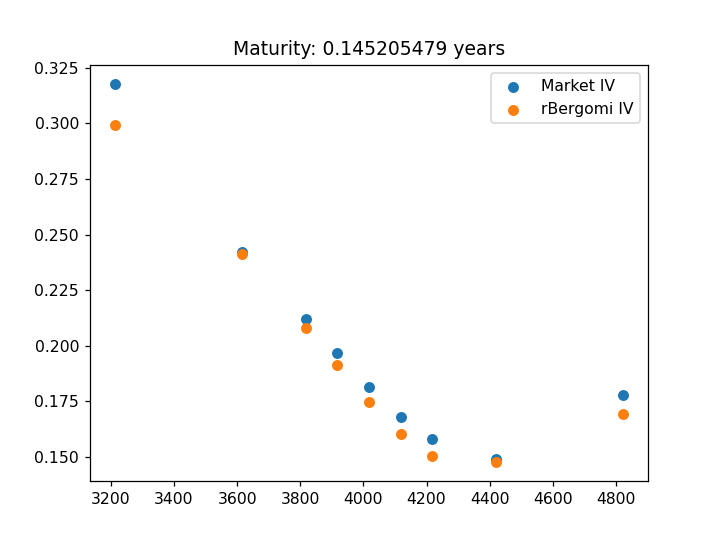

<IPython.core.display.Javascript object>


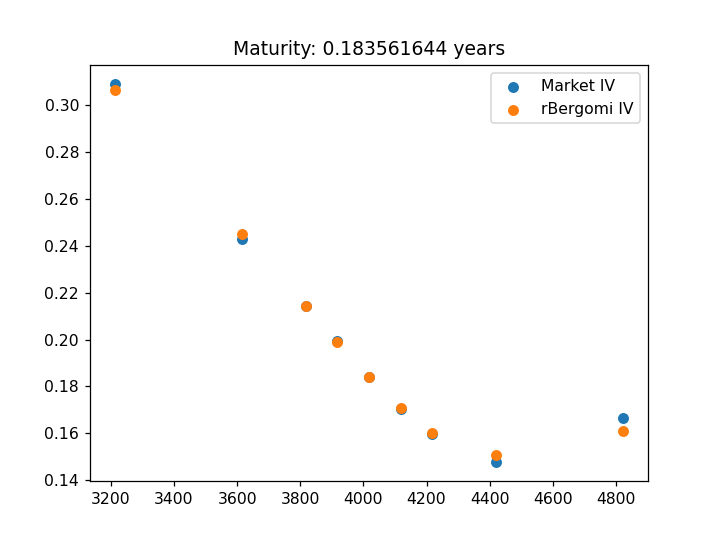

<IPython.core.display.Javascript object>


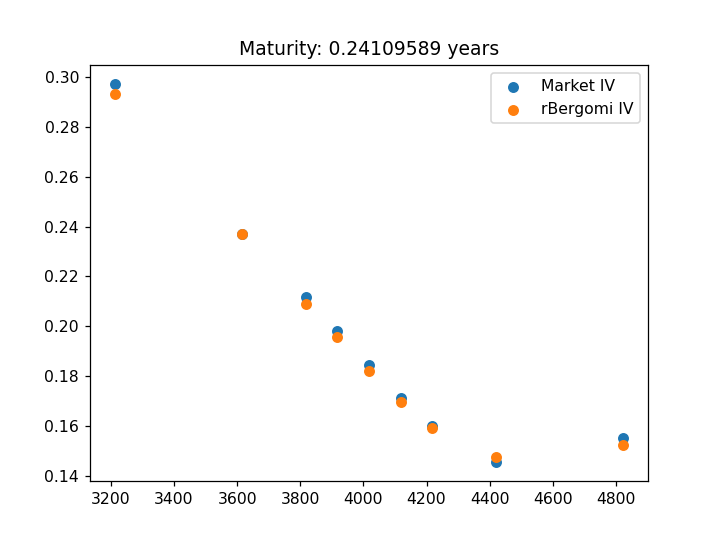

In [9]:
%matplotlib notebook

for i in range(5):
    plt.figure(i)
    plt.scatter(K, IV[i])
    plt.scatter(K, rB_vol[i,:])
    plt.legend(["Market IV","rBergomi IV"])
    plt.title(f'Maturity: {maturities[i]} years')

<IPython.core.display.Javascript object>


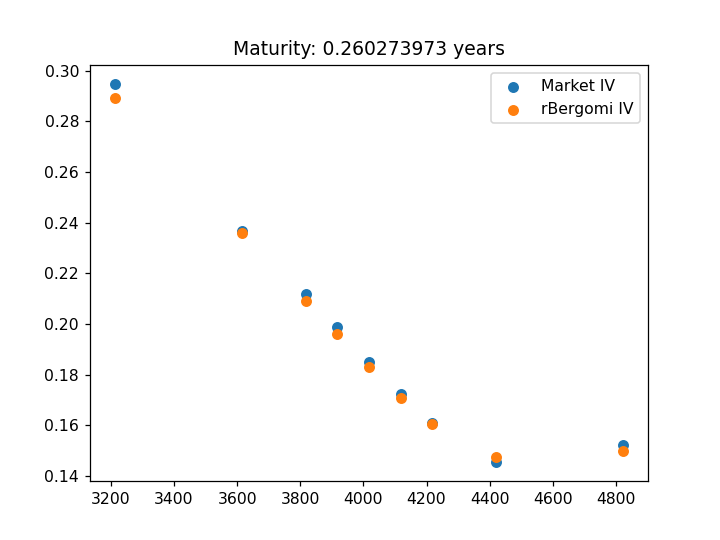

<IPython.core.display.Javascript object>


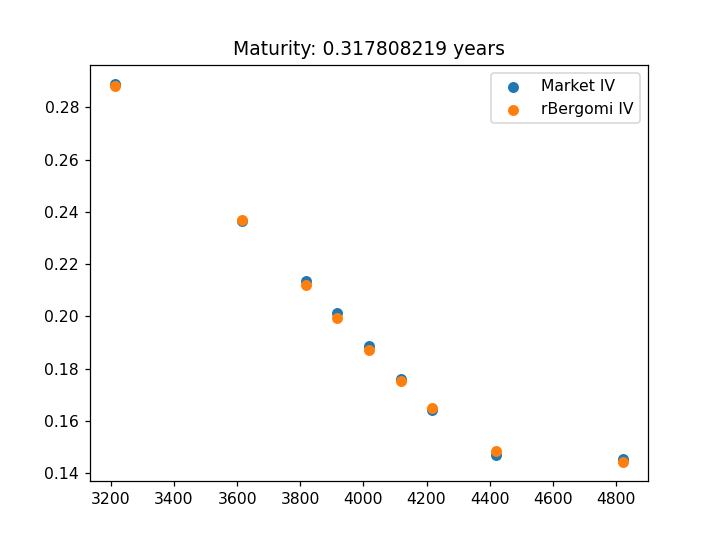

<IPython.core.display.Javascript object>


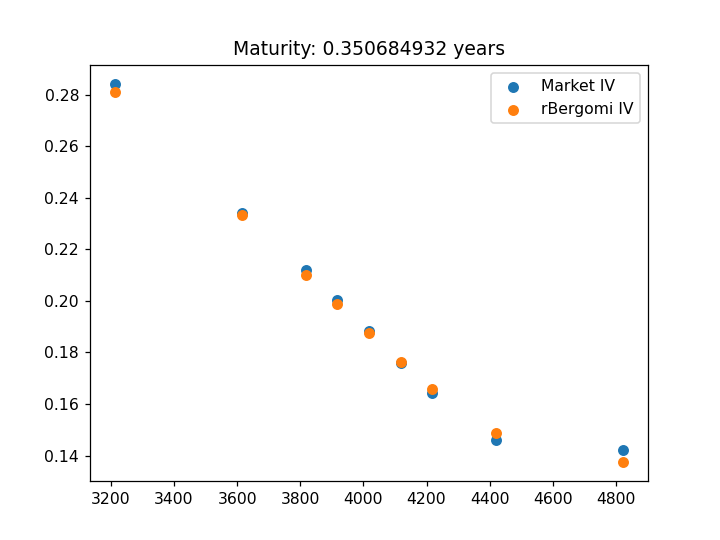

<IPython.core.display.Javascript object>


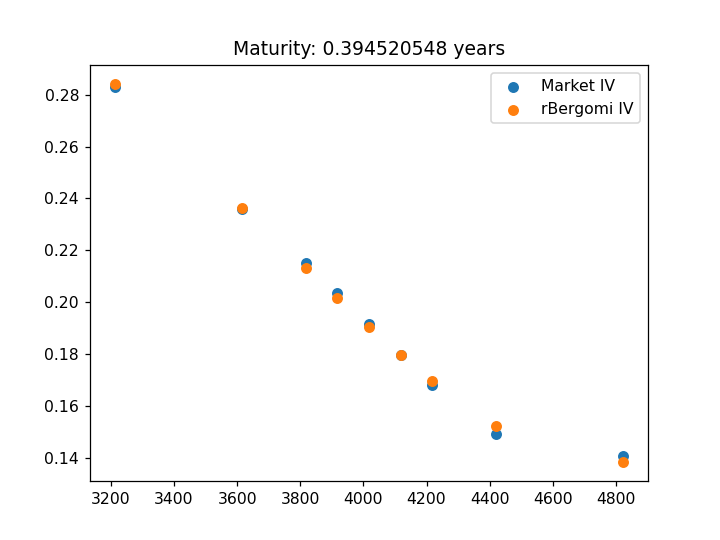

<IPython.core.display.Javascript object>


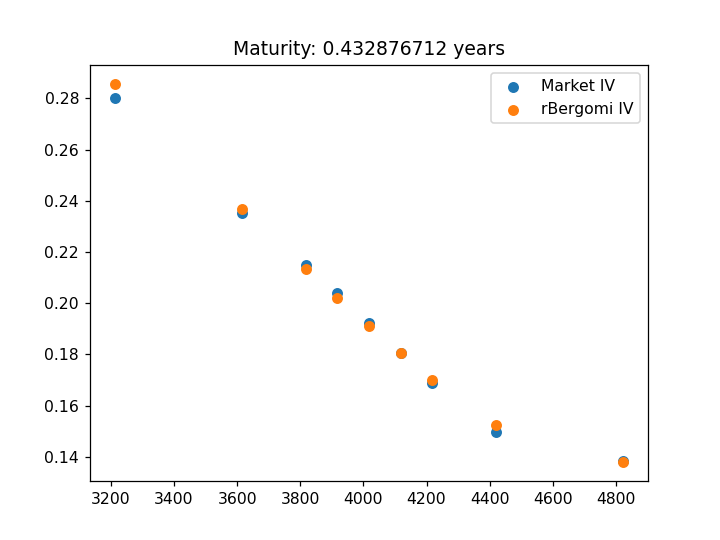

In [10]:
%matplotlib notebook

for i in range(5,10):
    plt.figure(i)
    plt.scatter(K, IV[i])
    plt.scatter(K, rB_vol[i,:])
    plt.legend(["Market IV","rBergomi IV"])
    plt.title(f'Maturity: {maturities[i]} years')

<IPython.core.display.Javascript object>


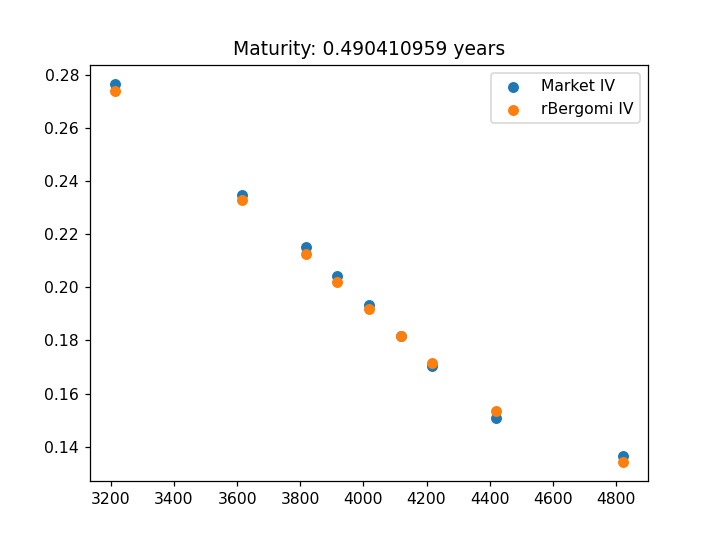

<IPython.core.display.Javascript object>


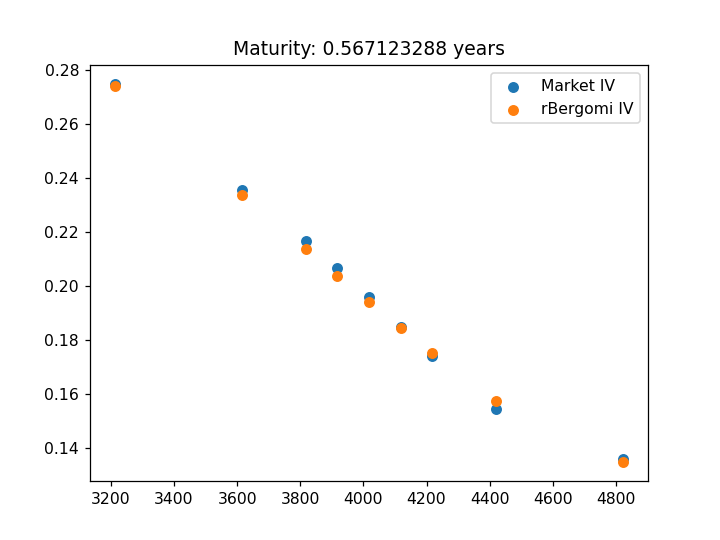

<IPython.core.display.Javascript object>


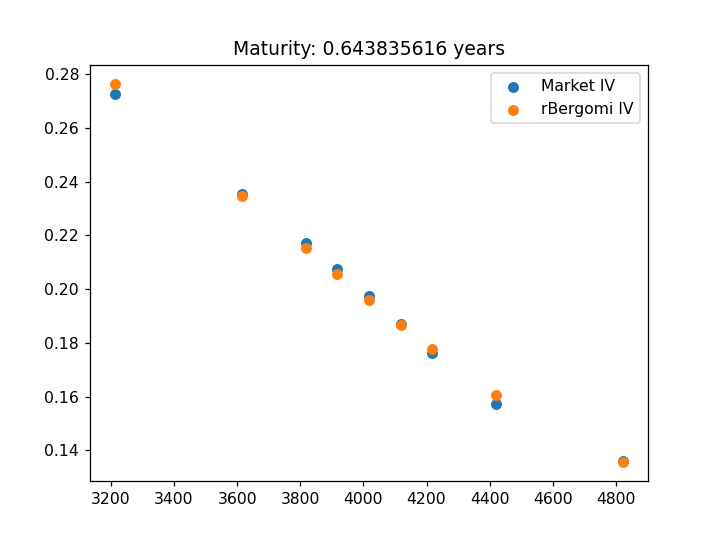

<IPython.core.display.Javascript object>


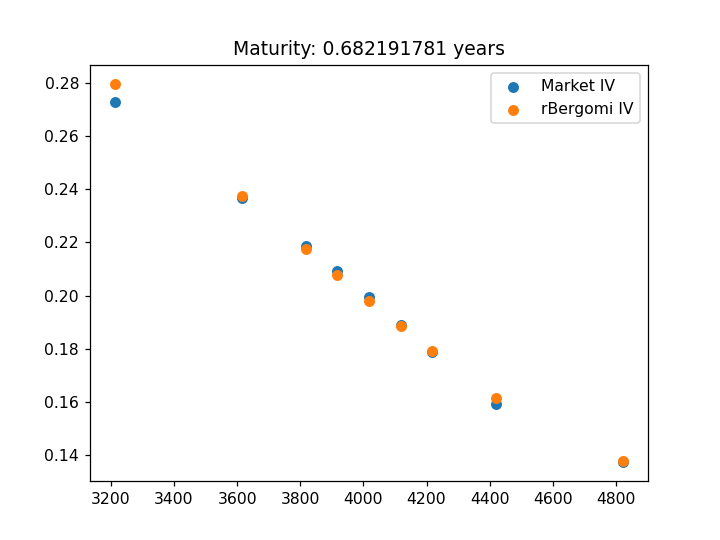

<IPython.core.display.Javascript object>


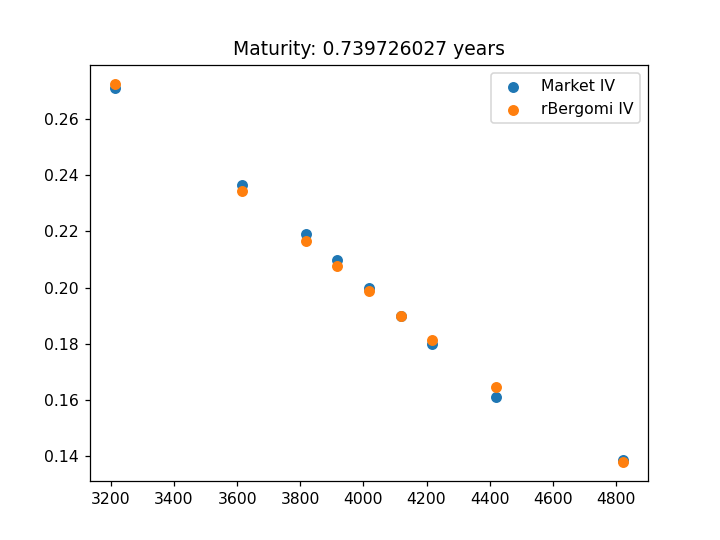

In [11]:
%matplotlib notebook

for i in range(10,15):
    plt.figure(i)
    plt.scatter(K, IV[i])
    plt.scatter(K, rB_vol[i,:])
    plt.legend(["Market IV","rBergomi IV"])
    plt.title(f'Maturity: {maturities[i]} years')

<IPython.core.display.Javascript object>


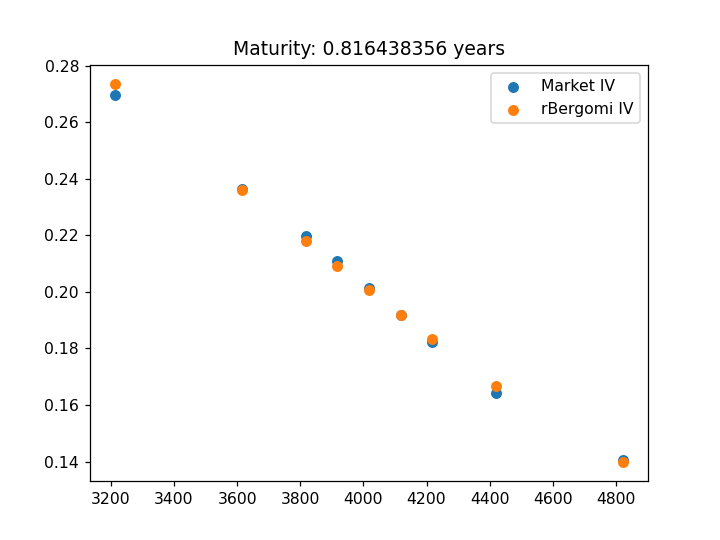

<IPython.core.display.Javascript object>


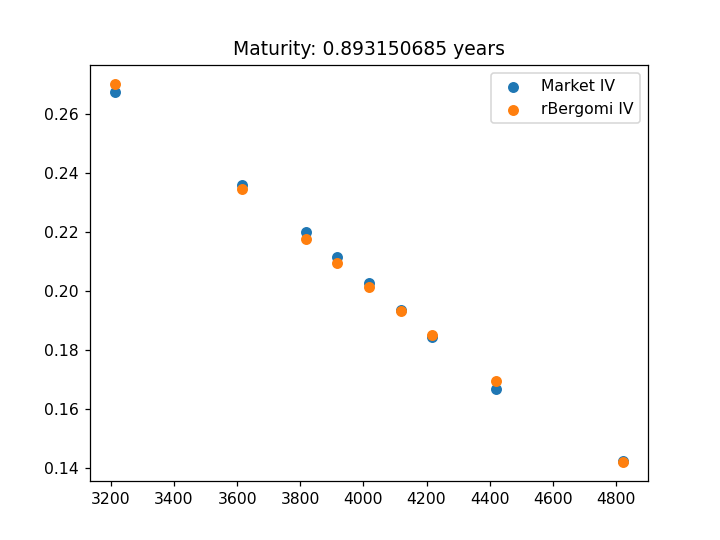

<IPython.core.display.Javascript object>


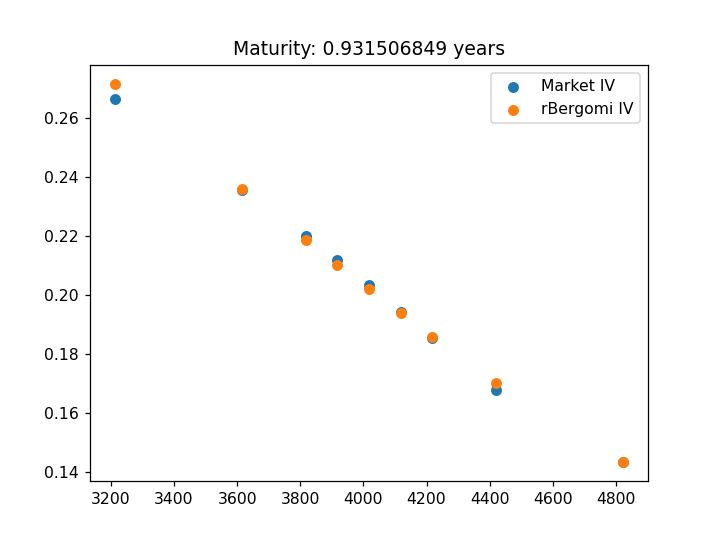

<IPython.core.display.Javascript object>


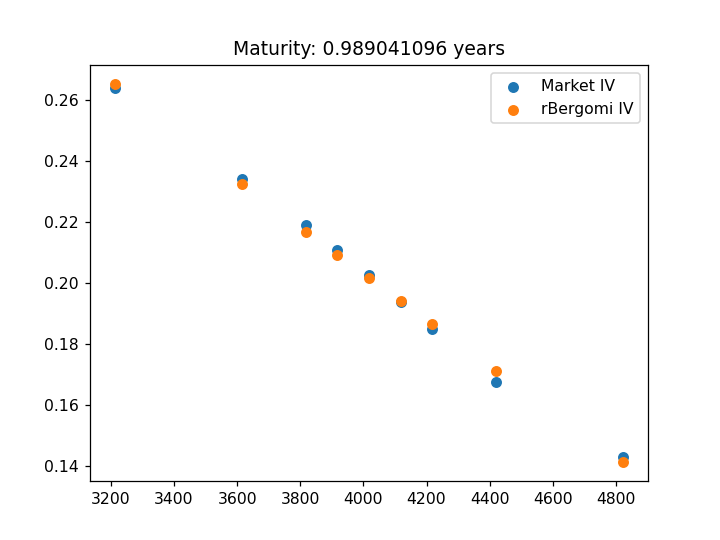

<IPython.core.display.Javascript object>


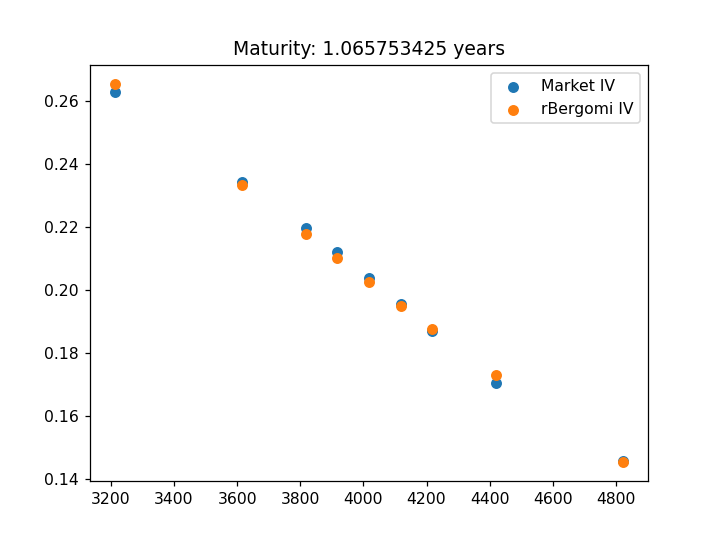

In [12]:
%matplotlib notebook

for i in range(15,20):
    plt.figure(i)
    plt.scatter(K, IV[i])
    plt.scatter(K, rB_vol[i,:])
    plt.legend(["Market IV","rBergomi IV"])
    plt.title(f'Maturity: {maturities[i]} years')

<IPython.core.display.Javascript object>


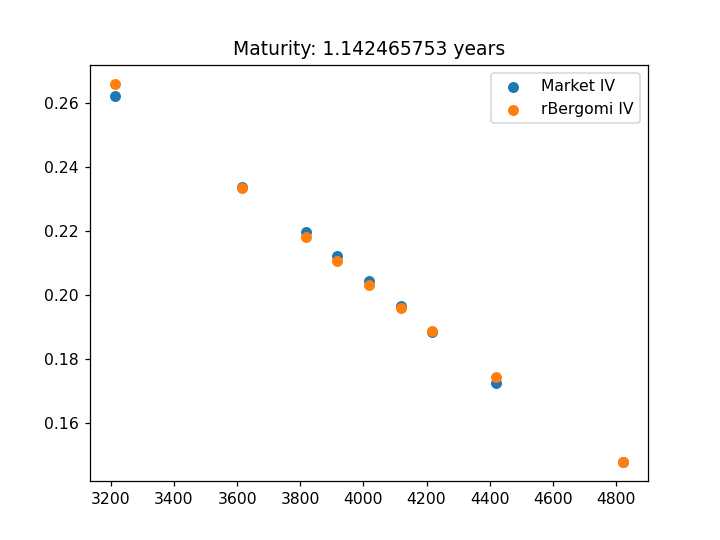

<IPython.core.display.Javascript object>


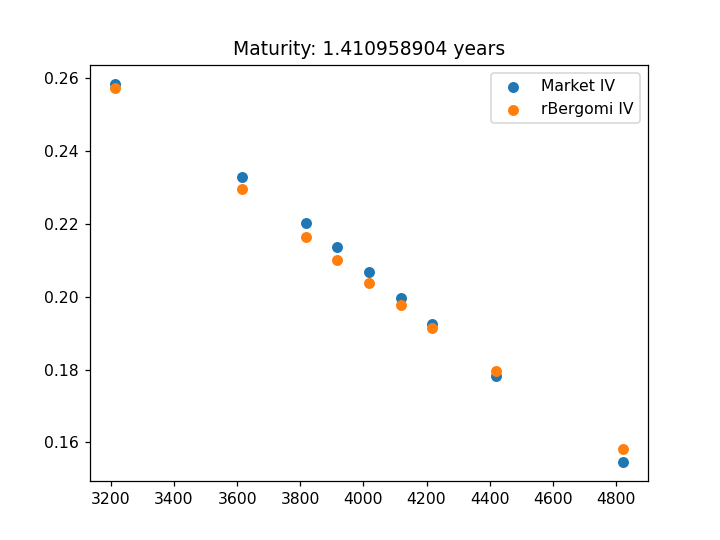

<IPython.core.display.Javascript object>


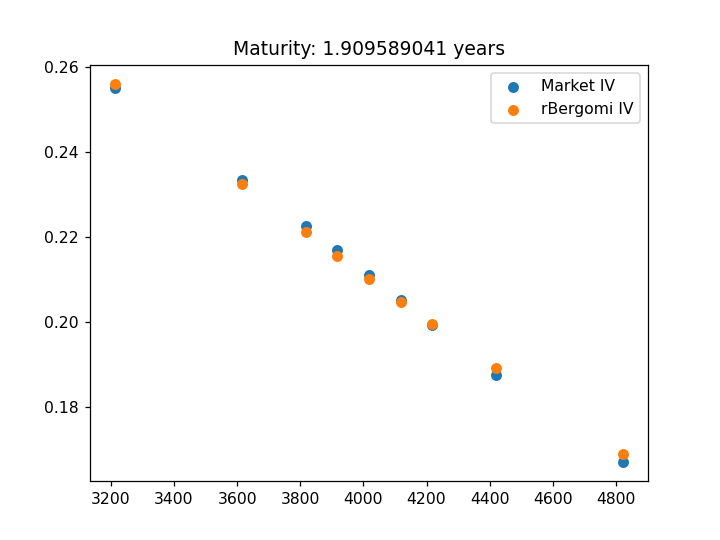

<IPython.core.display.Javascript object>


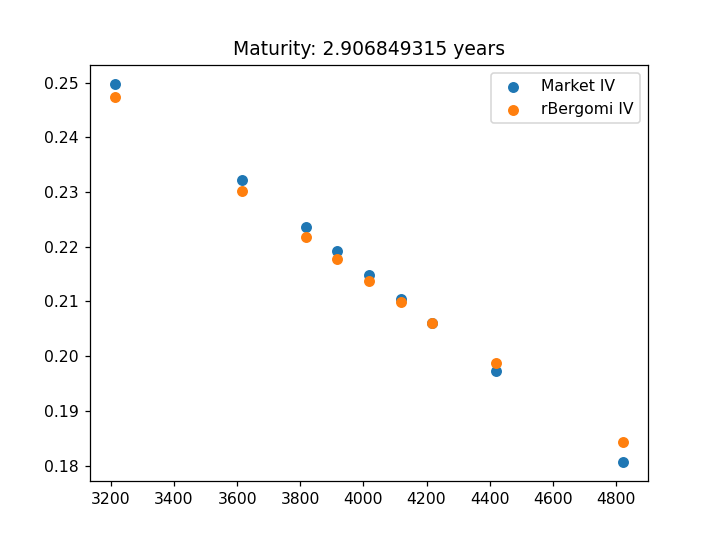

<IPython.core.display.Javascript object>


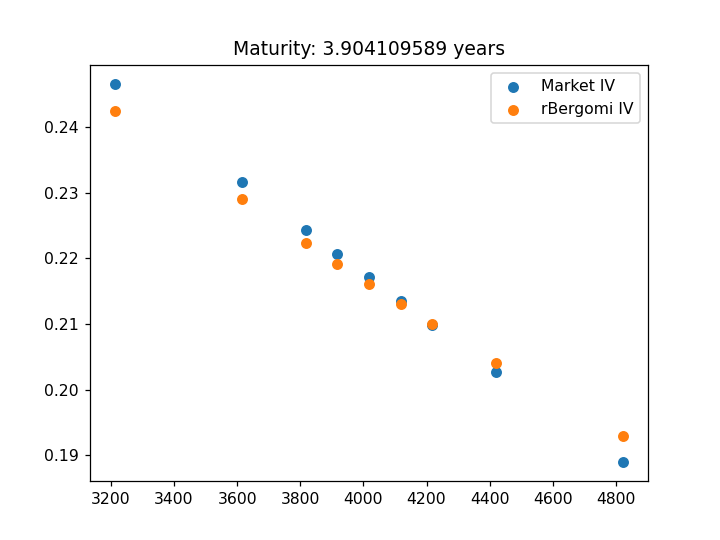

In [13]:
%matplotlib notebook

for i in range(20,25):
    plt.figure(i)
    plt.scatter(K, IV[i])
    plt.scatter(K, rB_vol[i,:])
    plt.legend(["Market IV","rBergomi IV"])
    plt.title(f'Maturity: {maturities[i]} years')

<IPython.core.display.Javascript object>


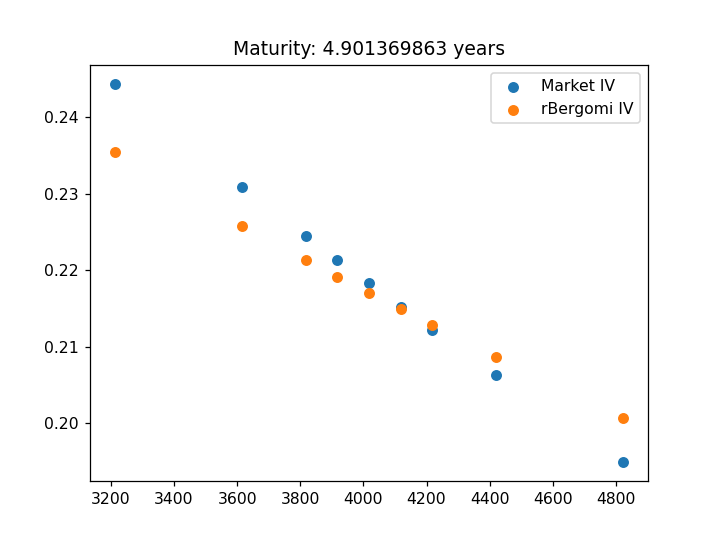

<IPython.core.display.Javascript object>


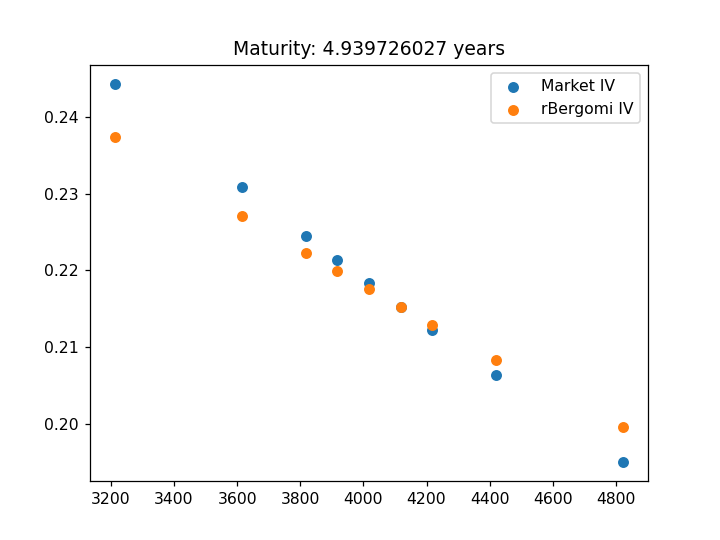

<IPython.core.display.Javascript object>


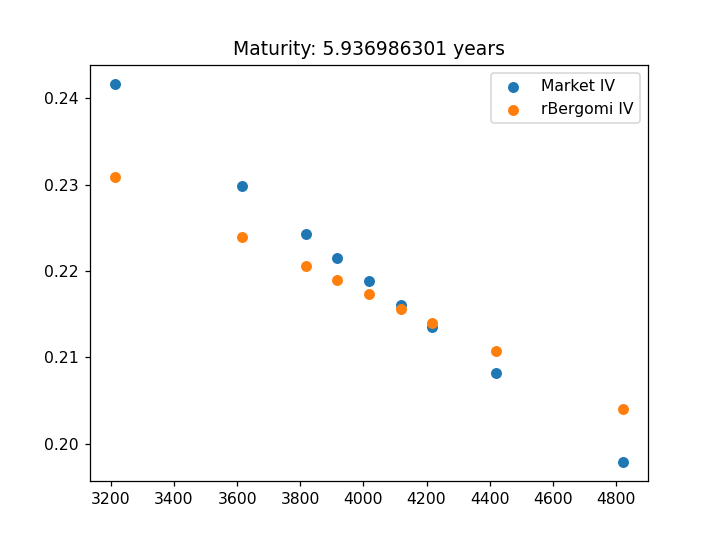

<IPython.core.display.Javascript object>


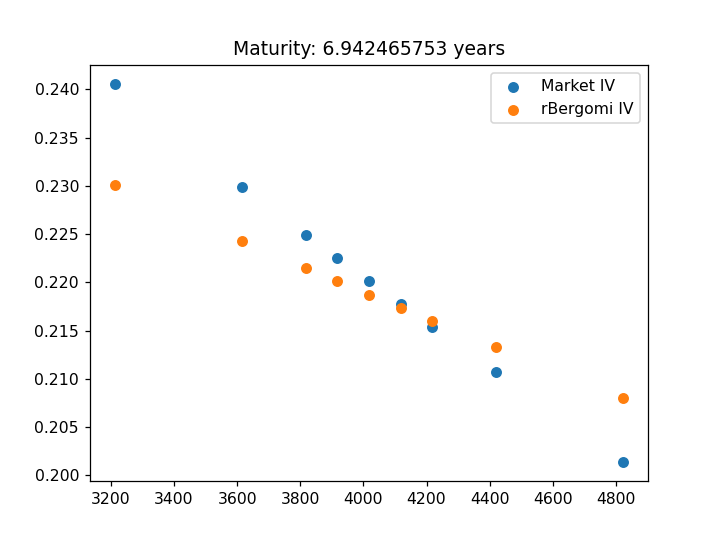

<IPython.core.display.Javascript object>


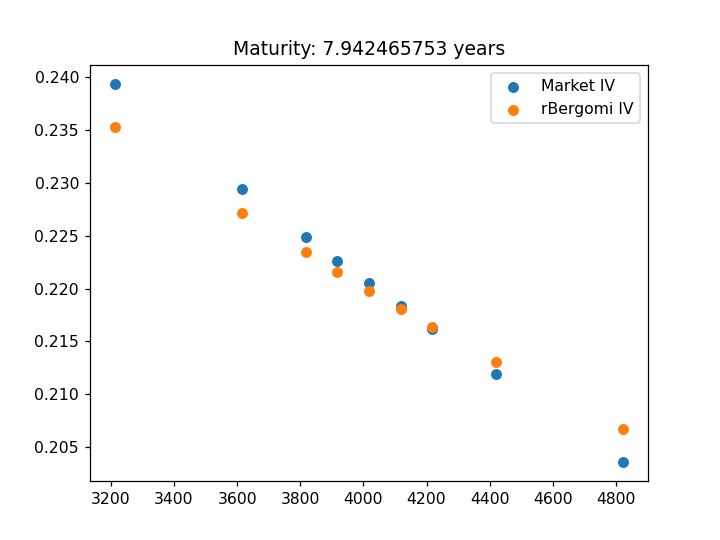

<IPython.core.display.Javascript object>


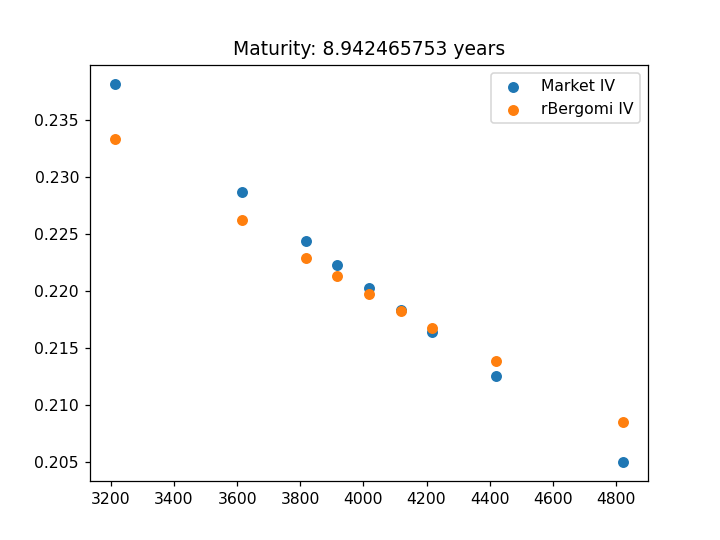

<IPython.core.display.Javascript object>


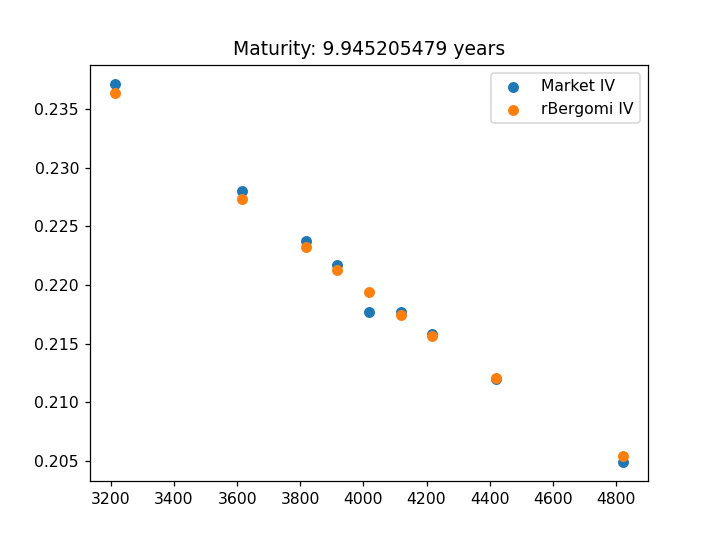

In [14]:
%matplotlib notebook

for i in range(25,32):
    plt.figure(i)
    plt.scatter(K, IV[i])
    plt.scatter(K, rB_vol[i,:])
    plt.legend(["Market IV","rBergomi IV"])
    plt.title(f'Maturity: {maturities[i]} years')

In [15]:
df = pd.DataFrame(rB_param, columns = ["H", "eta", "rho"])
df.to_csv("rB_parameters.csv", index = False)

In [16]:
db = pd.DataFrame(rB_vol)
db.to_csv("rB_iv.csv", index = False)

In [17]:
mean_error = 0
for i in range(32):
    mean_error += np.linalg.norm(rB_vol[i,:]-IV[i,:],2)
mean_error = mean_error / 32

print(mean_error)

0.009623927246728768


<IPython.core.display.Javascript object>


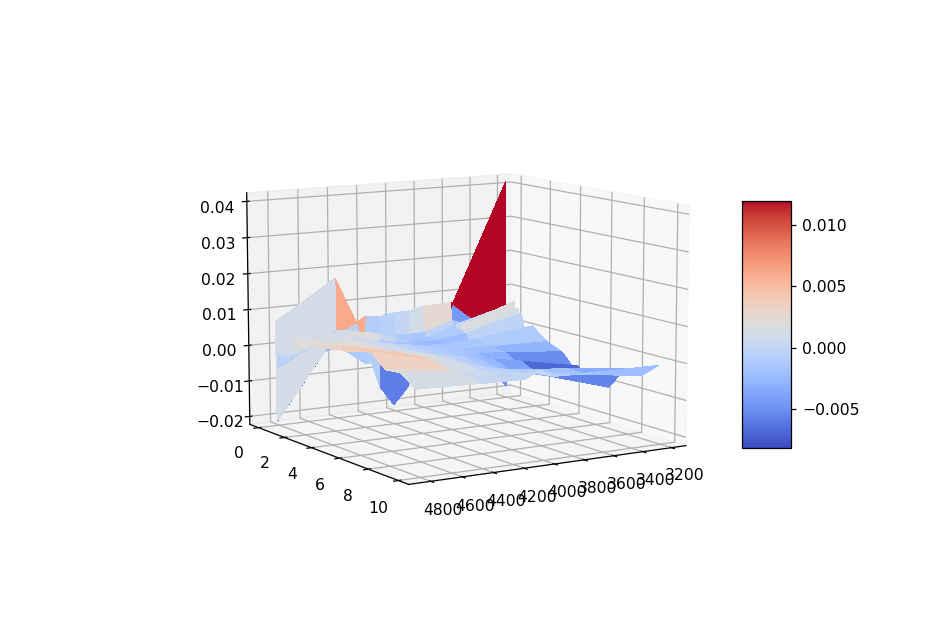

In [18]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
Y = maturities
X = K
X, Y = np.meshgrid(X, Y)
Z = rB_vol - IV

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()